11.	Implement a basic RNN for handling sequential data.
a.	Build an RNN for a time-series prediction task.
b.	Train on sequential data (e.g., stock prices).
c.	Evaluate the model using MSE or RMSE for regression tasks.
d.	Visualize predictions vs actual values over time.


In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


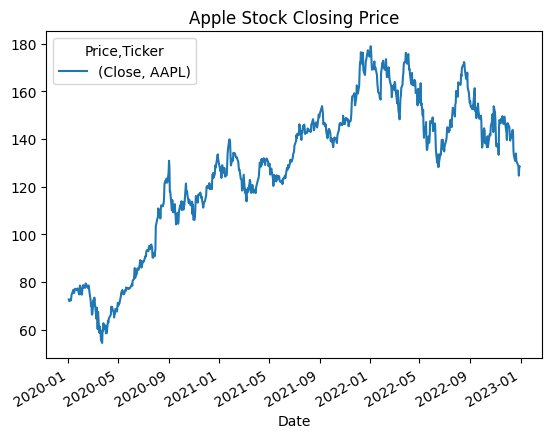

In [2]:
# Download data (e.g., Apple stock - AAPL)
data = yf.download("AAPL", start="2020-01-01", end="2023-01-01")
data = data[['Close']]  # Use only closing price

data.plot(title="Apple Stock Closing Price")
plt.show()


In [3]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train/test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)


In [16]:
class BasicRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(BasicRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # get output of the last time step
        return self.fc(out)

model = BasicRNN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [17]:
EPOCHS = 50

for epoch in range(EPOCHS):
    model.train()
    output = model(X_train)
    loss = loss_fn(output, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}")


Epoch [10/50], Loss: 0.0164
Epoch [20/50], Loss: 0.0024
Epoch [30/50], Loss: 0.0015
Epoch [40/50], Loss: 0.0015
Epoch [50/50], Loss: 0.0008


In [18]:
model.eval()
predicted = model(X_test).detach().numpy()
actual = y_test.numpy()

# Reverse scaling
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(actual)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 4.4804


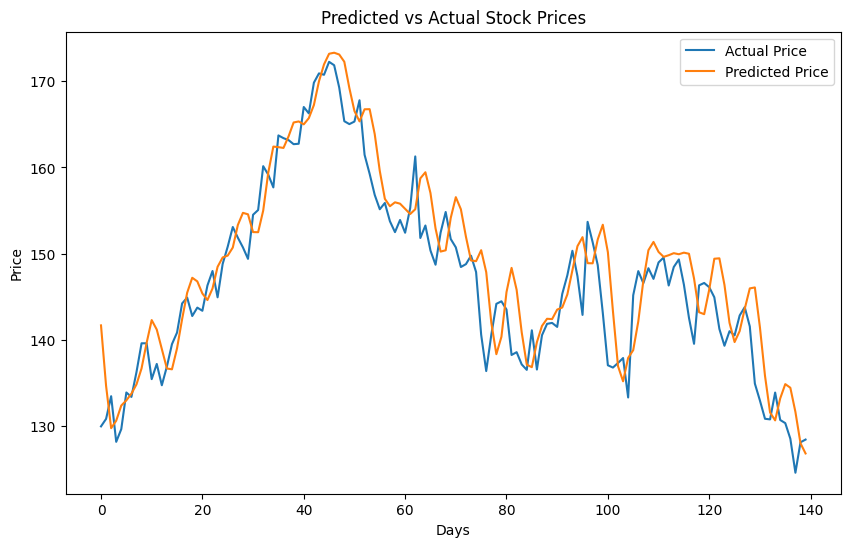

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
